In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from __future__ import print_function, division
import numpy as np 
import pandas as pd 
import scipy
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import datetime
import sys
import os
#from imageio import imread
import imageio
sys.path.append("/content/drive/My Drive/Projet DataScience") #Path Kayou
from Pipeline.Degradation import UglyImage

Using TensorFlow backend.


In [0]:
class DataLoader():
  def __init__(self, img_res=(128,128)):
    self.img_res = img_res
    self.train_path_files = '/content/drive/My Drive/Projet DataScience/Data/Train/dataset_clean_degraded'
    self.val_path_files = '/content/drive/My Drive/Projet DataScience/Data/Val/'

  def load_data(self, batch_size=1, is_val=True):
    """
    Return couples of images to visualize progress of the networks after epochs
    """
    
    path_files = self.train_path_files if not is_val else self.val_path_files

    clean_images = []
    degraded_images = []
    
    files = os.listdir(path_files + '/clean/')
    batch_images = np.random.choice(files, size=batch_size)

    for image in batch_images:
      clean = self.imread(path_files + '/clean/' + image)
      degraded = self.imread(path_files + '/degraded/' + image)

      # Decrease resolution
      clean = transform.resize(clean, self.img_res)
      degraded = transform.resize(degraded, self.img_res)

      # Data augmentation
      #if not is_val and np.random.random() < 0.5:
      #  clean_images = np.fliplr(clean_images)
      #  degraded_images = np.fliplr(degraded_images)

      clean_images.append(clean)
      degraded_images.append(degraded)

    #normalizing images
    clean_images = np.array(clean_images)/127.5 - 1.
    degraded_images = np.array(degraded_images)/127.5 -1.

    return clean_images, degraded_images

  def load_batch(self, batch_size=1, is_val=False):
    """
    Same function as load_data except for the fact that is used during training to load image in batches
    """
    
    path_files = self.train_path_files if not is_val else self.val_path_files

    n_batches = batch_size
    files = os.listdir(path_files + '/clean/')

    ugly = UglyImage(path=path_files + '/clean/', image_size=self.img_res)

    for i in range(n_batches):
      batch = files[i*batch_size:(i+1)*batch_size]
      
      #gen_data = ugly.loadImg(batch)
      #degraded_images, clean_images = next(gen_data)
      clean_images = []
      degraded_images = []

      for image in batch:
        clean_image_path = str(path_files + '/clean/' + image)
        degraded, clean = ugly.uglifyImage(clean_image_path)
 #       clean_image_path = str(path_files + '/clean/' + image)
 #       clean = self.imread(clean_image_path)
 #       degraded_image_path = str(path_files + '/degraded/' + image)
 #       degraded = self.imread(degraded_image_path)

        # decrease resolution
 #       clean = transform.resize(clean, self.img_res)
 #       degraded = transform.resize(degraded, self.img_res)

        # Data augmentation, trick to avoid overfitting
        #if not is_val and np.random.random() < 0.5:
        #  clean_images = np.fliplr(clean_images)
        #  degraded_images = np.fliplr(degraded_images)
        
        clean_images.append(clean)
        degraded_images.append(degraded)

      #normalizing images
      clean_images = np.array(clean_images)/127.5 - 1.
      degraded_images = np.array(degraded_images)/127.5 -1.

      yield clean_images, degraded_images

  def imread(self, path):
    return imageio.imread(path).astype(np.float)

In [0]:
class Pix2Pix():
  def __init__(self, img_rows=128, img_cols=128, channels=3):
    # Input shape
    self.img_rows = img_rows
    self.img_cols = img_cols
    self.channels = channels

    self.img_shape = (self.img_rows, self.img_cols, self.channels)

    # Configure DataLoader
    self.data_loader = DataLoader(img_res=(self.img_rows, self.img_cols))

    # Calculate output shape of D (PatchGAN)
    patchrows = int(self.img_rows / 2**4)
    patchcols = int(self.img_cols / 2**4)
    self.disc_patch = (patchrows, patchcols, 1)

    # Number of filters in the first layer of G and D
    self.gf = 64
    self.df = 64

    optimizer = Adam(0.0002, 0.5)

    self.generator_weights_filepath = 'weights_generator.hdf5'
    self.discriminator_weights_filepath = 'weights_discriminator.hdf5'


    # Build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='mse',
                optimizer=optimizer,
                metrics=['accuracy'])

    # Build the generator
    self.generator = self.build_generator()

    # Input images and their conditioning images
    clean_image = Input(shape=self.img_shape)
    degraded_image = Input(shape=self.img_shape)

    # By conditioning on degraded_image generate a fake version of clean_image
    fake_clean_image = self.generator(degraded_image)

    # For the combined model we will only train the generator
    self.discriminator.trainable = False

    # Discriminators determines validity of translated images / condition pairs
    valid = self.discriminator([fake_clean_image, degraded_image])

    self.combined = Model(inputs=[clean_image, degraded_image], outputs=[valid, fake_clean_image])
    self.combined.compile(loss=['mse', 'mae'],
                                  loss_weights=[1, 100],
                                  optimizer=optimizer)
    
  
  def build_generator(self):
    """
    U-Net Generator (to generate image)
    """

    def conv2d(input_layer, filters, f_size=4, bn=True):
      """
      Layers used during downsampling
      """
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(input_layer)
      d = LeakyReLU(alpha=0.2)(d)
      
      if bn:
        d = BatchNormalization(momentum=0.8)(d)
      
      return d

    def deconv2d(input_layer, skip_input, filters, f_size=4, dropout_rate=0):
      """
      Layers used during downsampling
      """
      u = UpSampling2D(size=2)(input_layer)
      u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)

      if dropout_rate:
        u = Dropout(dropout_rate)(u)
      
      u = BatchNormalization(momentum=0.8)(u)
      u = Concatenate()([u, skip_input])

      return u

    #Image Input
    d0 = Input(shape=self.img_shape)

    #Downsampling
    d1 = conv2d(d0, self.gf, bn=False)
    d2 = conv2d(d1, self.gf*2)
    d3 = conv2d(d2, self.gf*4)
    d4 = conv2d(d3, self.gf*8)
    d5 = conv2d(d4, self.gf*8)
    d6 = conv2d(d5, self.gf*8)
    d7 = conv2d(d6, self.gf*8)

    # Upsampling
    u1 = deconv2d(d7, d6, self.gf*8)
    u2 = deconv2d(u1, d5, self.gf*8)
    u3 = deconv2d(u2, d4, self.gf*8)
    u4 = deconv2d(u3, d3, self.gf*4)
    u5 = deconv2d(u4, d2, self.gf*2)
    u6 = deconv2d(u5, d1, self.gf)

    u7 = UpSampling2D(size=2)(u6)
    output_img = Conv2D(self.channels, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(d0, output_img)

  
  def build_discriminator(self):
  
    def d_layer(input_layer, filters, f_size=4, bn=True):
      """
      Discriminator layer
      """
      d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(input_layer)
      d = LeakyReLU(alpha=0.2)(d)

      if bn:
        d = BatchNormalization(momentum=0.8)(d)
      return d

    clean_image = Input(shape=self.img_shape)
    degraded_image = Input(shape=self.img_shape)

    # Concatenate image and conditioning image by chanels to produce input
    combined_imgs = Concatenate(axis=-1)([clean_image, degraded_image])

    d1 = d_layer(combined_imgs, self.df, bn=False)
    d2 = d_layer(d1, self.df*2)
    d3 = d_layer(d2, self.df*4)
    d4 = d_layer(d3, self.df*8)

    validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([clean_image, degraded_image], validity)

  
  def train(self, epochs, batch_size=1, show_interval=10):
    start_time = datetime.datetime.now()

    generator_best_loss = None
    discriminator_best_loss = None

    # Adversarial loss ground truths
    valid = np.ones((batch_size,) + self.disc_patch)
    fake = np.zeros((batch_size,) + self.disc_patch)

    for epoch in range(epochs):
        #print("start epoch : " + str(epoch))
        for batch_i, (clean_images, degraded_images) in enumerate(self.data_loader.load_batch(batch_size)):
            #print("start step : " + str(batch_i))

            # Train disciminator

            # Condition on degraded_images and translated version
            fake_clean_images = self.generator.predict(degraded_images)

            # Train the disciminators (orginal images = real / generated = Fake)
            d_loss_real = self.discriminator.train_on_batch([clean_images, degraded_images], valid)
            d_loss_fake = self.discriminator.train_on_batch([fake_clean_images, degraded_images], fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # Train generator
            g_loss = self.combined.train_on_batch([clean_images, degraded_images], [valid, clean_images])
            elapsed_time = datetime.datetime.now() - start_time
        
        
        if epoch % show_interval == 0:
          # Plot the progress
          print("[Epoch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs, d_loss[0], 100*d_loss[1], g_loss[0], elapsed_time))

          # If at show interval => show generated image samples
          self.show_images(epoch, batch_i)

        # Save models
        for model, best_loss, loss, model_weights_filepath in [[self.generator, generator_best_loss, g_loss[0], self.generator_weights_filepath], [self.discriminator, discriminator_best_loss, d_loss[0], self.discriminator_weights_filepath]]:
          if best_loss == None or best_loss > loss:
            best_loss = loss
            #model.save_weights(model_weights_filepath, True)
            model.save('model_saved_filepath.h5')
          else:
            pass

  def test(self, degraded_images, filepath_generator_weights):
    if os.path.isfile(filepath_generator_weights):
      self.generator.load_weights(filepath_generator_weights, True)
      print('generator weights loaded')
    else:
      print('ERROR : Generator weights not loaded')
    
    clean_images = self.generator.predict(degraded_images)
    return clean_images

  def show_images(self, epoch, batch_i):
        
    r, c = 3, 3

    clean_images, degraded_images = self.data_loader.load_data(batch_size=3, is_val=True)
    fake_clean_images = self.generator.predict(degraded_images)

    gen_imgs = np.concatenate([degraded_images, fake_clean_images, clean_images])

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    titles = ['Input', 'Output', 'Ground Truth']
    fig, axs = plt.subplots(r, c)
    fig.set_size_inches(12, 12)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt])
        axs[i, j].set_title(titles[i])
        axs[i,j].axis('off')
        cnt += 1
    plt.show()
    plt.close()

In [44]:
gan = Pix2Pix()
gan.train(epochs=15, batch_size=16, show_interval=1)

(128, 128)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: ignored

In [53]:
gan2 = Pix2Pix()
gan2.load_weights('/content/drive/My Drive/Projet DataScience/Weights/weights_generator_loss_4.837722.hdf5')
one_image = imageio.imread('/content/drive/My Drive/Projet DataScience/Data/Test/Photo/Dataset/0003.jpg').astype(np.float)
one_image = transform.resize(one_image, (128,128))

degraded_images = [one_image]

degraded_images = np.array(degraded_images)/127.5 - 1.

new_images = gan2.test(degraded_images, '/content/drive/My Drive/Projet DataScience/Weights/weights_generator_loss_4.837722.hdf5')


AttributeError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


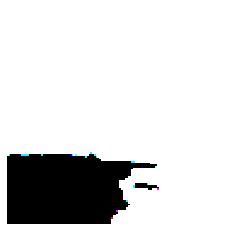

In [52]:
from matplotlib import pyplot as plt
new_image = new_images[0]
new_image = np.asarray(new_image) * 127.5 + 1.
plt.imshow(new_image)
plt.axis('off')
plt.show()

In [33]:
type(np.asarray(new_image, dtype=float))

ValueError: ignored